## Introduction

This project will seek to find the best location to open a new restaurant in Dublin, Ireland.

A friend of mine is a chef, and is keen to open a new restaurant in Dublin. She is quite flexible in her style of cooking, and is keen to understand what types of restaurant are most popular in the city to inform her plans. She would also like to find an area of the city in which to locate the restaurant. Ideally this should be somewhere with a number of other restaurants and amenities to provide footfall, but where her chosen style of restaurant has a chance to stand out from the crowd. She has asked me to look at Foursquare data to provide some recommendations.

## Data

For this analysis, I will use a csv file containing information on Dublin postal districts to define the different areas of the city, and data from the Foursquare API to get information on restaurants and other amenities in each district. Using this data, I will identify:

- The most popular restaurant styles in the city as a whole, informing my friend's choice for her own restaurant
- The areas of the city with the highest density of restaurants and amenities
- Among these, districts that have a gap for my friend's chosen cuisine style

I will also cluster the districts based on their most common venues, to provide alternative areas my friend might look at if it proves difficult to set up the restaurant in her preferred area.

## Methodology

### Identifying Dublin Districts

To begin with, we need to get location data for the different districts of the city. I have gathered this information in a csv file, and can read it into a *pandas* dataframe as follows:

In [2]:
import pandas as pd
import numpy as np

In [3]:
# The code was removed by Watson Studio for sharing.

,District,Neighborhoods,Latitude,Longitude
0,D1,"Abbey Street, Capel Street, Dorset Street, O'C...",53.35014,-6.266155
1,D2,"Merrion Square, Trinity, Temple Bar, Grafton S...",53.33990,-6.254300
2,D3,"North Strand, Clontarf, East Wall, Marino",53.36310,-6.221500
3,D4,"Ballsbridge, Donnybrook, Merrion, Ringsend, Sa...",53.32940,-6.227500
4,D5,"Artane, Coolock, Raheny",53.38410,-6.192100


In [4]:
dub_areas.shape

(21, 4)

We can see that there are 21 districts in the city, and that we have some information on the neighborhoods in each of the districts, as well as their latitude and longitude. This information will be used as the reference points for our Foursquare API queries.

Before we gather venue data, however, we can quickly build a map of Dublin and overlay points for each of the districts, so we can get a sense of the city's layout.

In [5]:
# Install Folium if required
!pip install folium

     |████████████████████████████████| 102kB 8.0MB/s ta 0:00:011


In [6]:
import folium # map rendering library
from geopy.geocoders import Nominatim

In [7]:
address = 'Dublin, IE'

geolocator = Nominatim(user_agent="dub-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dublin, Ireland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dublin, Ireland are 53.3497645, -6.2602732.


In [8]:
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dub_areas['Latitude'], dub_areas['Longitude'], dub_areas['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

Great - so we now have an idea of where each of the potential districts for the new restaurant are. Now, we need to get venue data from Foursquare.

### Getting data from the Foursquare API

In [9]:
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [10]:
# The code was removed by Watson Studio for sharing.

To begin with, we'll just get data for the D1 district

In [11]:
district_latitude = dub_areas.loc[0, 'Latitude'] # Postal Code latitude value
district_longitude = dub_areas.loc[0, 'Longitude'] # Postal Code longitude value

district_code = dub_areas.loc[0, 'District'] # Postal Code

print('Latitude and longitude values of {} are {}, {}.'.format(district_code, 
                                                               district_latitude, 
                                                               district_longitude))

Latitude and longitude values of D1 are 53.35014, -6.266155.


In [12]:
limit = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    district_latitude, 
    district_longitude, 
    radius, 
    limit)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=0M243W1YQQSMXJO2E1SJGDIZWS5FT1UBS5EHZ5MWVPUP4CNP&client_secret=FUMOBOWWO2CIYPSBGL20SNCWXF1MPMLHUFJX4FC2ZJMUXHGF&v=20180605&ll=53.35014,-6.266155&radius=500&limit=100'

In [13]:
results = requests.get(url).json()

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Black Sheep,Gastropub,53.349708,-6.269066
1,Dealz,Discount Store,53.350623,-6.263183
2,Blas Cafe,Coffee Shop,53.351336,-6.267326
3,BoCo,Pizza Place,53.351353,-6.269949
4,Cineworld,Multiplex,53.350244,-6.267696


In [15]:
nearby_venues.shape

(50, 4)

Great - we can see that we have been able to extract 50 venues within a 500m radius of D1. Now, let's repeat this for all of the districts in our list.

In [16]:
# Define function to loop through the various districts and extract the venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

dublin_venues = getNearbyVenues(names=dub_areas['District'],
                                 latitudes=dub_areas['Latitude'],
                                 longitudes=dub_areas['Longitude']
                                )

D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D20
D22
D24


In [17]:
print(dublin_venues.shape)
dublin_venues.head()

(257, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,D1,53.35014,-6.266155,The Black Sheep,53.349708,-6.269066,Gastropub
1,D1,53.35014,-6.266155,Dealz,53.350623,-6.263183,Discount Store
2,D1,53.35014,-6.266155,Blas Cafe,53.351336,-6.267326,Coffee Shop
3,D1,53.35014,-6.266155,BoCo,53.351353,-6.269949,Pizza Place
4,D1,53.35014,-6.266155,Cineworld,53.350244,-6.267696,Multiplex


In [18]:
dublin_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
D1,50,50,50,50,50,50
D10,5,5,5,5,5,5
D11,4,4,4,4,4,4
D12,5,5,5,5,5,5
D13,4,4,4,4,4,4
D14,5,5,5,5,5,5
D15,6,6,6,6,6,6
D16,5,5,5,5,5,5
D17,2,2,2,2,2,2


In [19]:
print('There are {} uniques categories.'.format(len(dublin_venues['Venue Category'].unique())))

There are 101 uniques categories.


We can see that there are 101 unique venue categories, and most venues are concentrated in the D1, D2, D4, and D24 districts.

### Determining the most common restaurant types

The first piece of information my friend needed to know was how common each type of restaurant was, so that she could make an informed decision on the style for her restaurant. To do this, we first need to filter our list of venues down to food places. We can review all the venue categories below:

In [20]:
dublin_venues['Venue Category'].unique()

array(['Gastropub', 'Discount Store', 'Coffee Shop', 'Pizza Place',
       'Multiplex', 'Clothing Store', 'Pub', 'Vietnamese Restaurant',
       'Recreation Center', 'Food & Drink Shop', 'Korean Restaurant',
       'Diner', 'Café', 'Nail Salon', 'Supermarket', 'Burrito Place',
       'Sushi Restaurant', 'Ice Cream Shop', 'Pharmacy', 'Gay Bar',
       'Hotel', 'Theater', 'Restaurant', 'Italian Restaurant',
       'Department Store', 'Bookstore', 'Mexican Restaurant',
       'Scenic Lookout', 'Post Office', 'Park', 'Grocery Store', 'Bar',
       'Bike Rental / Bike Share', 'Print Shop', 'Breakfast Spot',
       'Farmers Market', 'Hotel Bar', 'French Restaurant', 'Cocktail Bar',
       'Outdoor Sculpture', 'Art Museum', 'Liquor Store', 'Lounge',
       'Cheese Shop', 'Bakery', 'Whisky Bar', 'College Library',
       'Pedestrian Plaza', 'Seafood Restaurant', 'Steakhouse',
       'Wine Shop', 'Gym / Fitness Center', 'Museum', 'Bed & Breakfast',
       'Casino', 'Sandwich Place', 'Gym', 'Tha

As we can see, this isn't a particularly straighforward task, as there are a number of different labels that refer to restaurants. However, it looks like categories containing the words 'Restaurant', 'Joint', 'Place', 'Spot', 'Diner', and 'Gastropub' are our best bet. We can filter our results to only show venues containing these terms.

In [21]:
# Limit dataset to districts containing restaurants and eateries
searchfor = ['Restaurant', 'Joint', 'Place', 'Spot', 'Diner', 'Gastropub']
dublin_eateries=dublin_venues[dublin_venues['Venue Category'].str.contains('|'.join(searchfor))]
dublin_eateries.reset_index(drop=True, inplace=True)
dublin_eateries.shape

(57, 7)

In [22]:
dublin_eateries.head(20)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,D1,53.35014,-6.266155,The Black Sheep,53.349708,-6.269066,Gastropub
1,D1,53.35014,-6.266155,BoCo,53.351353,-6.269949,Pizza Place
2,D1,53.35014,-6.266155,Aobaba,53.348801,-6.268864,Vietnamese Restaurant
3,D1,53.35014,-6.266155,Arisu,53.348922,-6.268964,Korean Restaurant
4,D1,53.35014,-6.266155,Kingfisher Restaurant,53.351663,-6.263265,Diner
5,D1,53.35014,-6.266155,Boojum,53.347371,-6.265438,Burrito Place
6,D1,53.35014,-6.266155,Musashi Noodles & Sushi Bar,53.346968,-6.268147,Sushi Restaurant
7,D1,53.35014,-6.266155,The Winding Stair,53.346596,-6.263784,Restaurant
8,D1,53.35014,-6.266155,Il Fornaio,53.346773,-6.263193,Italian Restaurant
9,D1,53.35014,-6.266155,El Patron,53.350662,-6.270850,Mexican Restaurant


Alright - we now have a list of 57 restaurants. The next question is: how many are there of each type of restaurant?

In [23]:
dub_top=dublin_eateries.groupby('Venue Category').count().sort_values(by='Venue',ascending=False)
dub_top.head(10)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Italian Restaurant,5,5,5,5,5,5
Asian Restaurant,4,4,4,4,4,4
Fast Food Restaurant,4,4,4,4,4,4
Sandwich Place,4,4,4,4,4,4
Pizza Place,4,4,4,4,4,4
Indian Restaurant,4,4,4,4,4,4
Restaurant,4,4,4,4,4,4
Diner,3,3,3,3,3,3
Chinese Restaurant,3,3,3,3,3,3


In [24]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


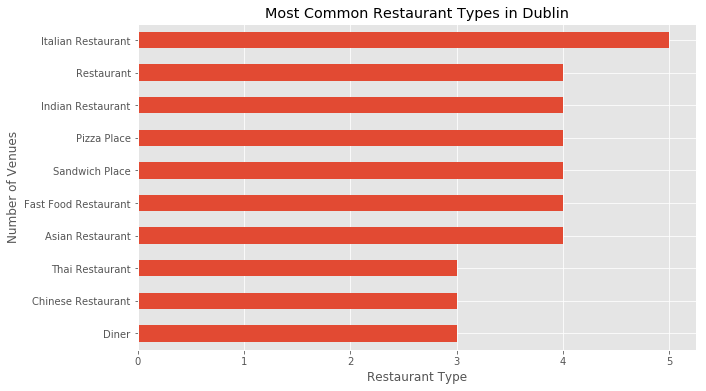

In [25]:
dub_top10=dub_top.head(10)
dub_top10.sort_values(by="Venue",ascending=True,inplace=True)

# step 2: plot data
dub_top10['Venue'].plot(kind='barh', figsize=(10, 6))

plt.xlabel('Restaurant Type') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Most Common Restaurant Types in Dublin') # add title to the plot

plt.show()

So we can see that the most common type of restaurant is *Italian*. *Indian*, *Pizza*, *Fast Food* and *Asian* are also quite common.

This information is quite helpful in terms of understanding what kind of food customers in Dublin are looking for. It also suggest that there is no single type of restaurant that has saturated the market, and gives any newcomer flexibility in their choice of style.

On the basis of this insight, my friend decides that she would like to open a new Italian restaurant. She ideally wants to be in a district that doesn't yet have one, but still has a strong restaurant scene to ensure footfall.

Firstly, we'll take a quick look at the Italian Restaurants in our dataset and where they're located.

In [68]:
# Limit dataset to Italian restaurants to find districts to avoid
dublin_italian=dublin_venues[dublin_venues['Venue Category'].str.contains('Italian Restaurant')]
dublin_italian.reset_index(drop=True, inplace=True)
dublin_italian.head(10)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,D1,53.35014,-6.266155,Il Fornaio,53.346773,-6.263193,Italian Restaurant
1,D2,53.33990,-6.254300,Cirillo's,53.337866,-6.252519,Italian Restaurant
2,D2,53.33990,-6.254300,Il Caffè di Napoli,53.342692,-6.250147,Italian Restaurant
3,D3,53.36310,-6.221500,Casa Pasta,53.362677,-6.218385,Italian Restaurant
4,D4,53.32940,-6.227500,Bellucci's,53.328631,-6.229507,Italian Restaurant


So we know that the 5 Italian restaurants are split among 4 districts, but it would be good to know whether these districts have a high number of restaurants, and whether Italian Restaurants are already the dominant player.

In [126]:
district_restaurants=dublin_eateries[['District','Venue']].groupby('District').count().reset_index()
district_restaurants.sort_values(by='Venue',ascending=False,inplace=True)
district_restaurants.reset_index(inplace=True,drop=True)
district_restaurants.columns=['District','Total Restaurants']

In [127]:
district_italian=dublin_venues[['District','Venue','Venue Category']].groupby('District')['Venue Category'].apply(lambda x: (x=='Italian Restaurant').sum()).reset_index(name='count')
district_italian.columns=['District','Italian Restaurants']

In [128]:
district_restaurants=district_restaurants.join(district_italian.set_index('District'), on='District')
district_restaurants

,District,Total Restaurants,Italian Restaurants
0,D1,13,1
1,D4,13,1
2,D24,11,0
3,D2,7,2
4,D9,4,0
5,D7,2,0
6,D10,1,0
7,D11,1,0
8,D15,1,0
9,D16,1,0


We can see that although there are already Italian restaurants in the D1 and D4 districts, they have a lot of other restaurants, so these could still be good locations to look at. D24 has 11 restaurants, none of which are Italian, so this is also a good option. However, D2 has 2 Italian restaurants out of a total of 7 - this is probably an area for us to avoid.

### Clustering Districts

We have an initial idea now of the districts that might be best to locate the new Italian restaurant. However, in order to be a bit more certain, we will look to cluster the districts based on the venues in each - restaurants and others. To do this, we'll first group the venues into "parent" categories - *Restaurants & Cafes*, *Retail Stores*, *Recreation & Fitness*, and *Other Amenities*. We'll then perform k-means clustering to identify groups of similar districts, which might provide additional insight on options for locating our new restaurant.

Our first task is to create a new column in the *Dublin Venues* dataset, to indicate the "parent" category for each venue.

In [129]:
# Define terms
Eateries = ['Restaurant', 'Joint', 'Place', 'Spot', 'Diner', 'Gastropub','Café','Coffee','Ice Cream','Bakery','Pub','Bar']
Retail = ['Shop','Store','Mall','Market','Bookstore']
Recreation = ['Gym','Sports','Spa','Salon','Court','Field','Stadium','Recreation']

# Create where loop to populate new column
dublin_venues['Type'] = np.where(
     dublin_venues['Venue Category'].str.contains('|'.join(Eateries)), 
    'Restaurants & Cafes', 
     np.where(
        dublin_venues['Venue Category'].str.contains('|'.join(Retail)), 'Retail Stores',
        np.where(
        dublin_venues['Venue Category'].str.contains('|'.join(Recreation)), 'Fitness & Leisure','Other Amenities') 
     )
)

dublin_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,D1,53.35014,-6.266155,The Black Sheep,53.349708,-6.269066,Gastropub,Restaurants & Cafes
1,D1,53.35014,-6.266155,Dealz,53.350623,-6.263183,Discount Store,Retail Stores
2,D1,53.35014,-6.266155,Blas Cafe,53.351336,-6.267326,Coffee Shop,Restaurants & Cafes
3,D1,53.35014,-6.266155,BoCo,53.351353,-6.269949,Pizza Place,Restaurants & Cafes
4,D1,53.35014,-6.266155,Cineworld,53.350244,-6.267696,Multiplex,Other Amenities


Next, we can use one-hot encoding to work out how many venues of a given "Type" there are in each district

In [130]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Type']], prefix="", prefix_sep="")

# add district column back to dataframe
dublin_onehot['District'] = dublin_venues['District'] 

# move district column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head()

dublin_grouped = dublin_onehot.groupby('District').mean().reset_index()
dublin_grouped

,District,Fitness & Leisure,Other Amenities,Restaurants & Cafes,Retail Stores
0,D1,0.040000,0.220000,0.560000,0.180000
1,D10,0.000000,0.200000,0.600000,0.200000
2,D11,0.000000,0.250000,0.750000,0.000000
3,D12,0.200000,0.200000,0.400000,0.200000
4,D13,0.250000,0.500000,0.000000,0.250000
5,D14,0.000000,0.200000,0.600000,0.200000
6,D15,0.000000,0.166667,0.500000,0.333333
7,D16,0.200000,0.200000,0.600000,0.000000
8,D17,0.000000,1.000000,0.000000,0.000000
9,D18,0.000000,1.000000,0.000000,0.000000


And now we'll create a *pandas* dataframe showing the order of venue types in each district

In [135]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Type'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = dublin_grouped['District']

for ind in np.arange(dublin_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,District,1st Most Common Venue Type,2nd Most Common Venue Type,3rd Most Common Venue Type,4th Most Common Venue Type
0,D1,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
1,D10,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
2,D11,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
3,D12,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
4,D13,Other Amenities,Retail Stores,Fitness & Leisure,Restaurants & Cafes


And now we're ready to run our k-means clustering algorithm

In [136]:
# set number of clusters
kclusters = 5

dublin_grouped_clustering = dublin_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dublin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 4, 1, 0, 1, 1, 4, 2, 2], dtype=int32)

In [137]:
# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dublin_merged = dub_areas

# merge dublin areas with data on total restaurants and Italian restaurants
dublin_merged = dublin_merged.join(district_restaurants.set_index('District'), on='District')

# join in venue type and cluster information
dublin_merged = dublin_merged.join(districts_venues_sorted.set_index('District'), on='District')

dublin_merged.head() # check the last columns!

,District,Neighborhoods,Latitude,Longitude,Total Restaurants,Italian Restaurants,Cluster Labels,1st Most Common Venue Type,2nd Most Common Venue Type,3rd Most Common Venue Type,4th Most Common Venue Type
0,D1,"Abbey Street, Capel Street, Dorset Street, O'C...",53.35014,-6.266155,13.0,1.0,1,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
1,D2,"Merrion Square, Trinity, Temple Bar, Grafton S...",53.33990,-6.254300,7.0,2.0,1,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
2,D3,"North Strand, Clontarf, East Wall, Marino",53.36310,-6.221500,1.0,1.0,4,Restaurants & Cafes,Other Amenities,Fitness & Leisure,Retail Stores
3,D4,"Ballsbridge, Donnybrook, Merrion, Ringsend, Sa...",53.32940,-6.227500,13.0,1.0,4,Restaurants & Cafes,Other Amenities,Fitness & Leisure,Retail Stores
4,D5,"Artane, Coolock, Raheny",53.38410,-6.192100,NaN,NaN,3,Other Amenities,Fitness & Leisure,Retail Stores,Restaurants & Cafes


Now that we have our clusters, we can display them on the map of Dublin we had created earlier

In [139]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dublin_merged['Latitude'], dublin_merged['Longitude'], dublin_merged['District'], dublin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

And finally, we can review specific clusters. We can see from the map that a plurality of districts fall into cluster 1, so we'll explore that first

In [141]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 1]

,District,Neighborhoods,Latitude,Longitude,Total Restaurants,Italian Restaurants,Cluster Labels,1st Most Common Venue Type,2nd Most Common Venue Type,3rd Most Common Venue Type,4th Most Common Venue Type
0,D1,"Abbey Street, Capel Street, Dorset Street, O'C...",53.35014,-6.266155,13.0,1.0,1,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
1,D2,"Merrion Square, Trinity, Temple Bar, Grafton S...",53.33990,-6.254300,7.0,2.0,1,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
6,D7,"Ashtown, Cabra, Phibsboro, Smithfield, Stoneyb...",53.36140,-6.291700,2.0,0.0,1,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
8,D9,"Drumcondra, Santry, Whitehall",53.38160,-6.246500,4.0,0.0,1,Retail Stores,Restaurants & Cafes,Other Amenities,Fitness & Leisure
9,D10,Ballyfermot,53.34070,-6.354400,1.0,0.0,1,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
11,D12,"Crumlin, Drimnagh, Walkinstown",53.32180,-6.316400,NaN,NaN,1,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
13,D14,"Churchtown, Clonskeagh, Dundrum, Goatstown",53.29580,-6.259300,NaN,NaN,1,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
14,D15,"Blanchardstown, Castleknock, Clonsilla, Mulhud...",53.39300,-6.416500,1.0,0.0,1,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
18,D20,"Chapelizod, Palmerstown",53.35160,-6.369400,1.0,0.0,1,Restaurants & Cafes,Retail Stores,Other Amenities,Fitness & Leisure
19,D22,"Clondalkin, Liffey Valley",53.32730,-6.400600,1.0,0.0,1,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure


We can see that cluster 1 districts tend to have restaurants or cafes as their most common venue type, and also tend to have a lot of retail stores. Recall that our earlier analysis had suggested D1, D4, or D24 as potential locations for our new Italian restaurant. 2 of these districts fall into cluster 1, as does D2, which we had ruled out on account of already having 2 Italian restaurants. We might also take the view that the other districts in this cluster could be good options for our location, given their similarity to the ones we had shortlisted.

However, we can see that D4 does not fall into this cluster, and it would be good to review this and any similar districts. Looking at the map, we can see that D4 is in cluster 4, so let's review that too:

In [143]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 4]

,District,Neighborhoods,Latitude,Longitude,Total Restaurants,Italian Restaurants,Cluster Labels,1st Most Common Venue Type,2nd Most Common Venue Type,3rd Most Common Venue Type,4th Most Common Venue Type
2,D3,"North Strand, Clontarf, East Wall, Marino",53.3631,-6.2215,1.0,1.0,4,Restaurants & Cafes,Other Amenities,Fitness & Leisure,Retail Stores
3,D4,"Ballsbridge, Donnybrook, Merrion, Ringsend, Sa...",53.3294,-6.2275,13.0,1.0,4,Restaurants & Cafes,Other Amenities,Fitness & Leisure,Retail Stores
10,D11,"Ballymun, Finglas, Glasnevin",53.3897,-6.2929,1.0,0.0,4,Restaurants & Cafes,Other Amenities,Retail Stores,Fitness & Leisure
15,D16,"Ballinteer, Ballyboden, Knocklyon",53.2799,-6.2790,1.0,0.0,4,Restaurants & Cafes,Other Amenities,Fitness & Leisure,Retail Stores


Looking at the districts in this cluster, we can see that they all have restaurants and cafes at their most common venue, but are less retail-focused than the districts in cluster 1. Depending on the ambience the chef wishes to achieve in the restaurant, these districts, may be a better option for our location. For example, cluster 1 locations may suit a restaurant looking to capitalise on lunchtime trade from busy shoppers, while cluster 4 might better suit a more relaxing restaurant away from the hustle and bustle.